In [16]:
import pandas as pd
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

import numpy as np

import sklearn
import scikit_posthocs as sp
import statsmodels.formula.api as sfa
import statsmodels.api as sa
import os
from pathlib import Path

import scipy
import neurokit2 as nk

import tqdm 

from collections import Counter
import matplotlib.pyplot as plt


In [17]:
lstPIds = []
path = "./Data/"
for filename in os.listdir(path):
    if filename.endswith(".csv"): 
        lstPIds.append(int(filename.split("-")[0].replace("ID", "")))
    else:
        continue
lstPIds = list(set(lstPIds))
print(lstPIds)

[1, 2, 3, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [18]:
lstAll = []
for pid in tqdm.tqdm(lstPIds):
    
    dfState = pd.read_csv(f"{path}ID{pid}-state.csv")

    dfStart = dfState[dfState.State == "start"].copy()
    dfEnd = dfState[dfState.State == "end"][["Time"]].iloc[:len(dfStart)]
    dfStart = dfStart.rename(columns={"Time":"TimeStart"})
    dfStart.TimeStart = dfStart.TimeStart #+ 60
    dfStart["TimeEnd"] = dfEnd.Time.values
    del dfStart["State"]
    dfStart["Duration"] = dfStart.TimeEnd - dfStart.TimeStart
    df = dfStart[dfStart.BlockNumber != -2].copy()

    dfNBack = pd.read_csv(f"{path}ID{pid}-feedback.csv")
    dfNBack = dfNBack[dfNBack.Time != "Time"]
    correct= (dfNBack["IsCorrect"]==True).count()

    lstNBack = []
    for i, e in df.iterrows():
        dfX = dfNBack[(dfNBack.Time > e.TimeStart) & (dfNBack.Time < e.TimeEnd )]
        if (len(dfX) == 0):
            print("No Data!")
        lstNBack.append(dfX.IsCorrect.mean())
    df["IsCorrect"] = lstNBack

    lstCorrectCount = []
    lstTotalTouchCount = []
    #lstNBack = []
    for i, e in df.iterrows():
        dfX = dfNBack[(dfNBack.Time > e.TimeStart) & (dfNBack.Time <= e.TimeEnd )]
        lstCorrectCount.append(len(dfX[dfX.IsCorrect == True]))
        lstTotalTouchCount.append(len(dfX))
    
    dfSphere = pd.read_csv(f"{path}ID{pid}-sphere.csv")
    del dfSphere["Feedback"]
    
    lstMissedCount = []
    for i, e in df.iterrows():
        dfX = dfSphere[(dfSphere.Time > e.TimeStart) & (dfSphere.Time <= e.TimeEnd )].reset_index(drop=True)
        missed = 0
        for i in range(0, len(dfX)-1):
            if ((dfX.iloc[i].Type == "up") & (dfX.iloc[i+1].Type == "down")):
                if(dfX.iloc[i+1].Time-dfX.iloc[i].Time > 4):
                    missed += 1
        lstMissedCount.append(missed)
    
    df["NBackCorrect"] = lstCorrectCount
    df["NBackMissed"] = lstMissedCount
    df["NBackTotal"] = np.array(lstTotalTouchCount) + np.array(lstMissedCount)
    df["NBackAccuracy"] = df["NBackCorrect"]/df["NBackTotal"] * 100
    
    df["NBackTimePerBall"] = df["Duration"] / np.array(lstTotalTouchCount)
    
    
    # Read Flow File
    dfFlow = pd.read_csv(f"{path}ID{pid}-flow.csv")
    dfFlow["TimeNorm"] = dfFlow.Time-dfState.Time.iloc[0]

    # Read Visitor File
    #dfLiams = pd.read_csv(f"{path}ID{pid}-visitor.csv")
    #dfLiams = dfLiams.drop_duplicates(subset=['Name'])
    #dfLiams["TimeNorm"] = dfLiams.Time-dfState.Time.iloc[0]

   ## Calculate Accuracy
    lstLiamData = []
    for i, e in df.iterrows():
        dfX = dfFlow[(dfFlow.Time > e.TimeStart) & (dfFlow.Time < e.TimeEnd )]
       
        if ((len(dfX) == 0)):
            print("No Data! Liams" + str(i))
           
        lstLiamData.append(len(dfX))
        
    #lstLiamClickData.append([total, truePositive, falsePositive, trueNegatives, falseNegatives])
    #lstLiamClickData = np.array(lstLiamClickData)
    df["LiamsCountTotal"] = lstLiamData
    #df["LiamsCounTruePositive"] = lstLiamClickData[:,1]
    #df["LiamsCountFalsePositive"] = lstLiamClickData[:,2]
    #df["LiamsCountTrueNegatives"] = lstLiamClickData[:,3]
    #df["LiamsCountFalseNegatives"] = lstLiamClickData[:,4]

   # df["Accuracy"] = (df.LiamsCounTruePositive +  df.LiamsCountTrueNegatives) / df.LiamsCountTotal
    df["Flow"] = df["LiamsCountTotal"] / df.Duration * 60
    # Read EDA
    dfEDA = pd.read_csv(f"{path}ID{pid}-EDA.csv")
    edaFs = 250  # Sampling frequency

    dfEDA.Value = (dfEDA.Value / 1000) / 25
    dfEDA["TimeNorm"] = dfEDA.Time-dfState.Time.iloc[0]
    dfEDA["EDAClean"] =  nk.eda_clean(dfEDA["Value"], sampling_rate=edaFs) #scipy.signal.medfilt(dfEDA.Value, edaFs +1)
    #sos = scipy.signal.butter(1, 0.01, btype='lowpass', analog=False, output='sos', fs=edaFs)
    #dfEDA["EDAButter"] = scipy.signal.sosfilt(sos, dfEDA["EDAMedian"])
    #signal, info=nk.eda_process(nk.standardize(dfEDA.EDAClean, sampling_rate=edaFs), sampling_rate=edaFs)
    #signal2, info = nk.eda_sympathetic(dfEDA.EDAClean, sampling_rate=edaFs, frequency_band=[0.045, 0.25], method='posada', show=False)
    signal, info=nk.eda_process(dfEDA.EDAClean, sampling_rate=edaFs)
    dfEDA["EDARaw"] = signal.EDA_Raw
    dfEDA["EDATonic"] = signal.EDA_Tonic
    dfEDA["EDAPhasic"] = signal.EDA_Phasic
    #dfEDA["EDASCR"] = signal.SCR_Amplitude
    #dfEDA["EDASymp"] = signal2.EDA_Symp
    
    
    lstEDATonic = []
    lstEDARaw = []
    lstEDAMedian = []
    lstEDAButter = []
    lstEDAPhasic = []
    #lstEDASCR = []
    #lstEDAFre = []
    
    for i, e in df.iterrows():
        dfX  =dfEDA[(dfEDA.Time > e.TimeStart) & (dfEDA.Time < e.TimeEnd )]
        lstEDATonic.append(dfX.EDATonic.mean())
        lstEDARaw.append(dfX.EDARaw.mean())
        lstEDAPhasic.append(dfX.EDAPhasic.mean())
        #lstEDASCR.append(dfX.EDASCR.mean())
        #lstEDAFre.append(dfX.EDAFre.mean())
        #lstEDAMedian.append(dfX.EDAClean.mean())
        #lstEDAButter.append(dfX.EDAButter.mean())

    df["EDATonic"] = lstEDATonic
    df["EDARaw"] = lstEDARaw
    df["EDAPhasic"] = lstEDAPhasic
    #df["EDASCR"] = lstEDASCR
    #df["EDAClean"] = lstEDAClean
    #df["EDAButter"] = lstEDAButter
   # dfEDA["EDASymp"] = lstEDASymp
    df["PId"] = pid
    lstAll.append(df)
    
dfAll = pd.concat(lstAll)


100%|██████████| 17/17 [00:22<00:00,  1.32s/it]


In [19]:
dfAll

,TimeStart,BlockNumber,AdaptationStatus,NBackN,TimeEnd,Duration,IsCorrect,NBackCorrect,NBackMissed,NBackTotal,NBackAccuracy,NBackTimePerBall,LiamsCountTotal,Flow,EDATonic,EDARaw,EDAPhasic,PId
0,1.662020e+09,1,1,2,1.662020e+09,360.01669,0.915730,163,0,178,91.573034,2.022566,146,24.332205,6.075239,6.075241,0.000002,1
2,1.662020e+09,6,1,2,1.662021e+09,360.35229,0.941463,193,0,205,94.146341,1.757816,1688,281.058294,7.970107,7.970232,0.000125,1
4,1.662021e+09,4,1,2,1.662021e+09,360.05591,0.817734,166,0,203,81.773399,1.773674,1637,272.790967,8.826208,8.826936,0.000728,1
6,1.662022e+09,2,1,2,1.662022e+09,360.02358,0.904977,200,0,221,90.497738,1.629066,664,110.659419,9.316826,9.318431,0.001604,1
8,1.662022e+09,7,2,2,1.662023e+09,360.03858,0.730159,138,3,192,71.875000,1.904966,1174,195.645700,9.707646,9.709179,0.001533,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1.662648e+09,7,2,2,1.662648e+09,360.08251,0.877451,179,1,205,87.317073,1.765110,1302,216.950276,9.732461,9.732633,0.000173,20
6,1.662649e+09,3,1,2,1.662649e+09,360.04636,0.847059,216,0,255,84.705882,1.411947,1155,192.475213,10.356211,10.357670,0.001459,20
8,1.662649e+09,2,1,2,1.662649e+09,360.01682,0.901818,248,0,275,90.181818,1.309152,658,109.661543,10.263372,10.264708,0.001336,20
10,1.662650e+09,5,1,2,1.662650e+09,360.06204,0.888889,232,1,262,88.549618,1.379548,2058,342.940900,10.090248,10.089888,-0.000360,20


In [20]:
for pid in tqdm.tqdm(lstPIds):
    
    dfState = pd.read_csv(f"{path}ID{pid}-state.csv")

    dfStart = dfState[dfState.State == "start"].copy()
    dfEnd = dfState[dfState.State == "end"][["Time"]].iloc[:len(dfStart)]
    dfStart = dfStart.rename(columns={"Time":"TimeStart"})
    dfStart.TimeStart = dfStart.TimeStart #+ 60
    dfStart["TimeEnd"] = dfEnd.Time.values
    del dfStart["State"]
    dfStart["Duration"] = dfStart.TimeEnd - dfStart.TimeStart
    df = dfStart[dfStart.BlockNumber != -2].copy()
        
    dfEEG = pd.read_csv(f"{path}ID{pid}-EEG.csv")
    dfEEG = dfEEG.rename(columns={"Value0": "F3", "Value1": "C3", "Value2": "P3", "Value3": "P4", "Value4": "C4", "Value5": "F4", "Value6": "Pz"})
    dfEEG.drop(['Value7'], axis=1)
    dfEEG["TimeNorm"] = dfEEG.Time-dfState.Time.iloc[0]
    sampling_freq = 250 #was 300
    ch_names = ['F3','C3','P3','P4','C4','F4','Pz']
    ch_types = ['eeg'] * 7
    #lstF3 = []
    #lstC3 = []
    #lstP3 = []
    #lstP4 = []
    #lstC4 = []
    #lstF4 = []
    #lstPz = []
    
      # for i, e in df.iterrows():
      #     dfX = dfEEG[(dfEEG.Time > e.TimeStart) & (dfEEG.Time < e.TimeEnd )]
      #     lstF3.append(dfX.F3)
      #     lstC3.append(dfX.C3)
      #     lstP3.append(dfX.P3)
      #     lstP4.append(dfX.P4)
      #     lstC4.append(dfX.C4)
      #     lstF4.append(dfX.F4)
      #     lstPz.append(dfX.Pz)
      #     lstAll.append(dfX)
      #     
      #     dfX["F3"] = lstF3
      #     dfX["C3"] = lstC3
      #     dfX["P3"] = lstP3 
      #     dfX["P4"] = lstP4
      #     dfX["C4"] = lstC4
      #     dfX["F4"] = lstF4
      #     dfX["Pz"] = lstPz
    
    
    
    
      #     dfX["PId"] = pid
      #     lstAll.append(df)
    
        #df["EDASCR"] = lstEDASCR
        #df["EDAClean"] = lstEDAClean
        #df["EDAButter"] = lstEDAButter
       # dfEDA["EDASymp"] = lstEDASymp
        #df["PId"] = pid
       # lstAll.append(df)
        
    #dfAll = pd.concat(lstAll)

    

100%|██████████| 17/17 [00:11<00:00,  1.46it/s]


In [21]:
dfEEG

,Time,TimeLsl,F3,C3,P3,P4,C4,F4,Pz,Value7,TimeNorm
0,1.662647e+09,1.397284e+06,-7781.753,-8558.176,-8585.615,-8852.667,-8271.696,-9299.825,-8997.875,0,-83.48460
1,1.662647e+09,1.397284e+06,-8877.694,-10939.210,-10376.270,-10431.000,-9807.197,-11136.400,-10872.470,0,-83.48460
2,1.662647e+09,1.397284e+06,-9862.867,-11011.970,-10688.140,-10381.140,-10341.650,-10765.390,-10862.360,0,-83.48460
3,1.662647e+09,1.397284e+06,7423.864,8581.715,8350.145,8790.847,8350.954,9203.478,8999.828,0,-82.71707
4,1.662647e+09,1.397284e+06,9021.572,11096.360,10447.180,10745.830,9975.814,11347.610,10862.000,0,-82.71707
...,...,...,...,...,...,...,...,...,...,...,...
1018995,1.662650e+09,1.400681e+06,4462.024,-1463.819,1557.447,4975.773,-1540.379,2080.329,1625.108,0,3313.56765
1018996,1.662650e+09,1.400681e+06,4477.977,-1439.423,1580.034,4974.239,-1518.694,2093.888,1638.954,0,3313.56765
1018997,1.662650e+09,1.400681e+06,4458.111,-1440.896,1569.214,4952.866,-1522.872,2081.503,1630.522,0,3313.56765
1018998,1.662650e+09,1.400681e+06,4483.395,-1405.361,1584.547,4947.699,-1509.354,2080.154,1632.639,0,3313.56765


In [22]:
dfEEG.drop("Time", axis =1, inplace=True)
dfEEG.drop("TimeLsl", axis =1, inplace=True)
dfEEG.drop("Value7", axis =1, inplace=True)
dfEEG.drop("TimeNorm", axis =1, inplace=True)
dfEEG

,F3,C3,P3,P4,C4,F4,Pz
0,-7781.753,-8558.176,-8585.615,-8852.667,-8271.696,-9299.825,-8997.875
1,-8877.694,-10939.210,-10376.270,-10431.000,-9807.197,-11136.400,-10872.470
2,-9862.867,-11011.970,-10688.140,-10381.140,-10341.650,-10765.390,-10862.360
3,7423.864,8581.715,8350.145,8790.847,8350.954,9203.478,8999.828
4,9021.572,11096.360,10447.180,10745.830,9975.814,11347.610,10862.000
...,...,...,...,...,...,...,...
1018995,4462.024,-1463.819,1557.447,4975.773,-1540.379,2080.329,1625.108
1018996,4477.977,-1439.423,1580.034,4974.239,-1518.694,2093.888,1638.954
1018997,4458.111,-1440.896,1569.214,4952.866,-1522.872,2081.503,1630.522
1018998,4483.395,-1405.361,1584.547,4947.699,-1509.354,2080.154,1632.639


In [95]:
ch_types = ["eeg"]*dfEEG.shape[1]
ch_names = ['F3','C3','P3','P4','C4','F4','Pz']  
sfreq=300
montage = mne.channels.make_standard_montage("standard_1020")
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
samples = dfEEG.T*1e-6
raw = mne.io.RawArray(samples, info)
raw.set_montage(montage = montage)

Creating RawArray with float64 data, n_channels=7, n_times=1019000
    Range : 0 ... 1018999 =      0.000 ...  3396.663 secs
Ready.


<RawArray | 7 x 1019000 (3396.7 s), ~54.4 MB, data loaded>

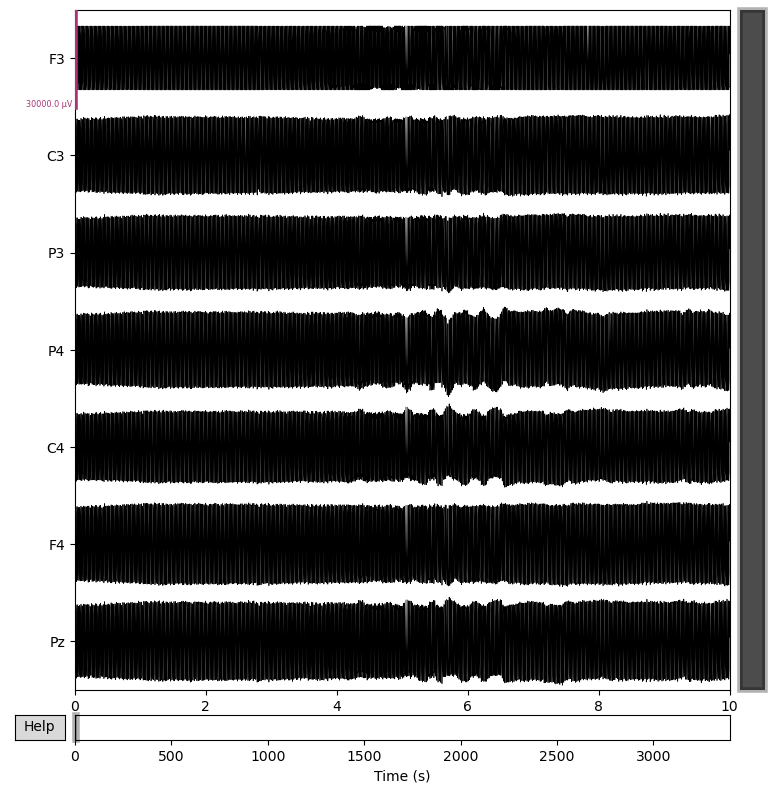

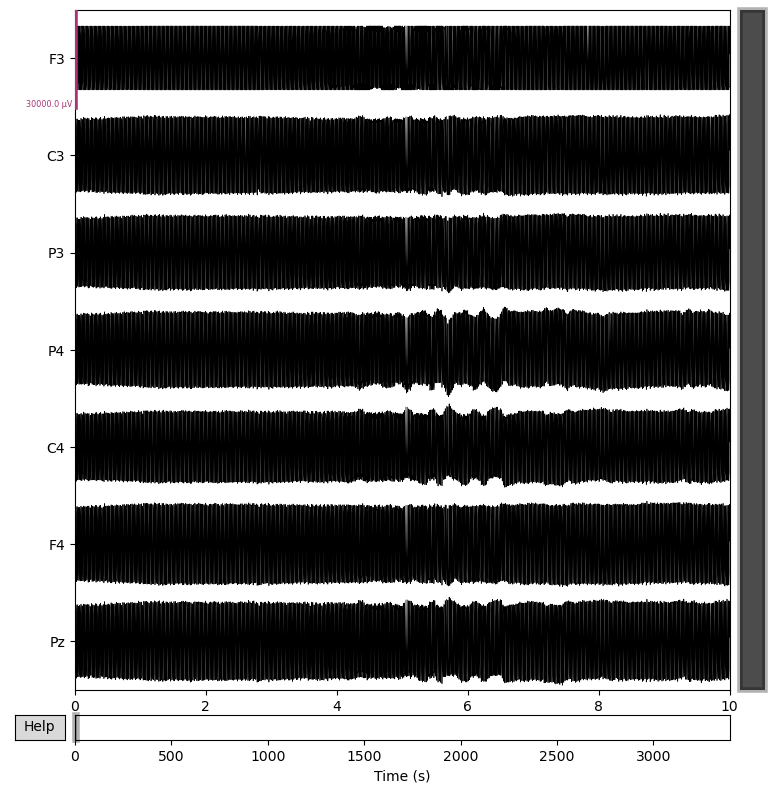

In [96]:
#raw.plot()
raw.plot(scalings=150e-4, n_channels=7)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1981 samples (6.603 sec)

Effective window size : 6.827 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


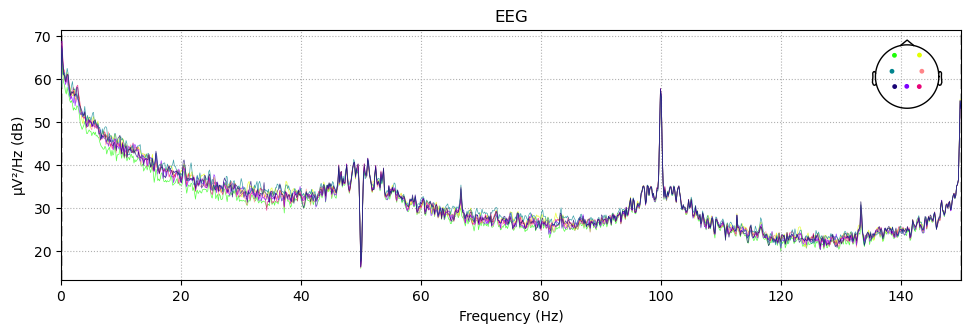

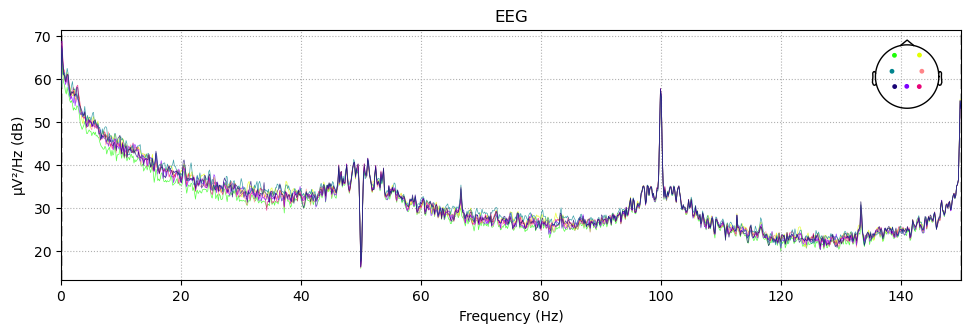

In [25]:
#apply notch filter
#filter specific freq
#filter EEG artifact of the electric grid
raw.notch_filter(50)
raw.plot_psd()

Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


/tmp/ipykernel_23514/1972786548.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.0s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1698 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1698 matching events found
No baseline correction applied
0 projection items activated


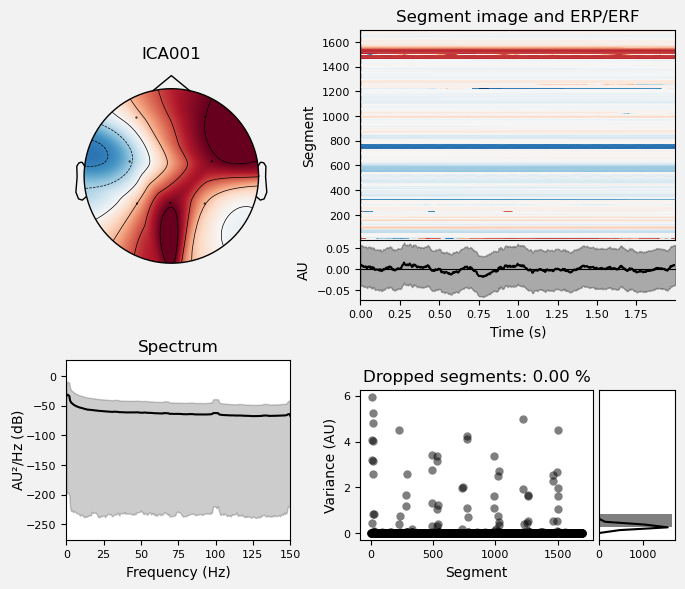

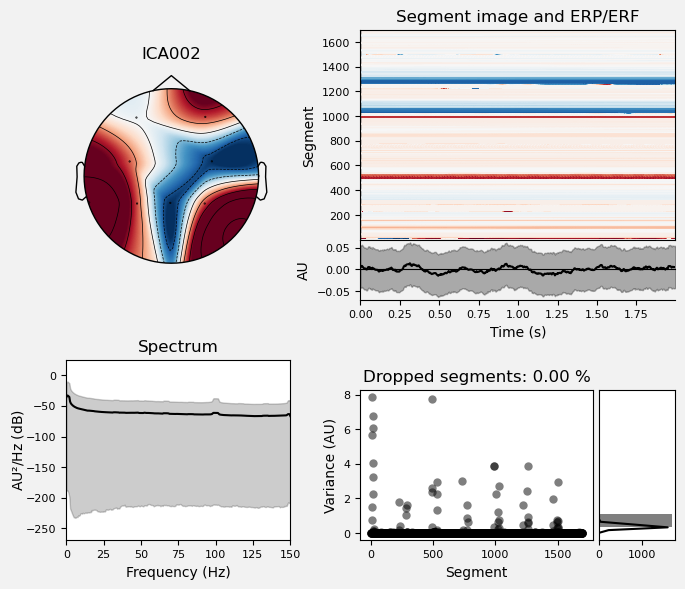

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [26]:
ica = mne.preprocessing.ICA(n_components=7, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

## FIltering

Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


/tmp/ipykernel_23514/3646637594.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1698 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1698 matching events found
No baseline correction applied
0 projection items activated


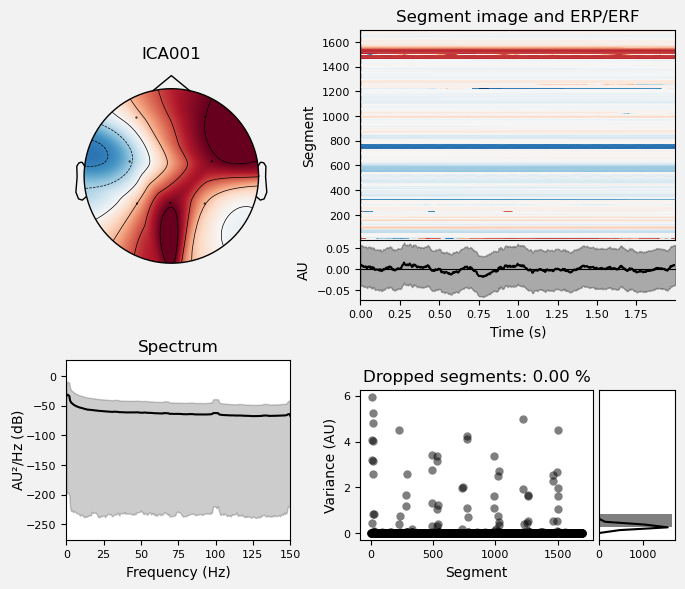

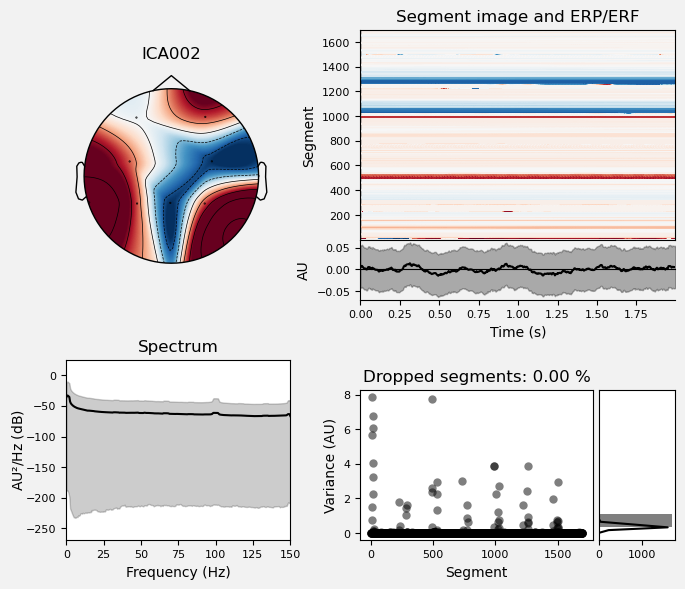

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [27]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=7, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

In [28]:
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)

NameError: name 'chs' is not defined

In [ ]:
#loadedRaw.notch_filter(np.arange(50, 151, 50)) 

mne.filter.filter_data(raw, 300, l_freq=7.5, h_freq=12.5)  

In [ ]:
#bandpass filter, cut signal outside the EEG spectrum
raw.filter(l_freq = 1, h_freq = 60)
raw.plot_psd(0.5, 40, 0,360)


## Old


In [ ]:
dfEEG.drop(['Value7'], axis=1)
dfEEG = dfEEG.rename(columns={"Value0": "F3", "Value1": "C3", "Value2": "P3", "Value3": "P3", "Value4": "C4", "Value5": "F4", "Value6": "Pz"})
dfEEG["TimeNorm"] = dfEEG.Time-dfState.Time.iloc[2]
dfEEG

In [ ]:
#define info EEG RAW
sfreq = 300
#ch_types = ["eeg"]*dfEEG.shape[1]
ch_types = ['eeg'] * 7
ch_names = ["F3","C3","P3","P4","C4","F4","Pz"]
montage = mne.channels.make_standard_montage("standard_1020")
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
loadedRaw = mne.io.RawArray(dfEEG["F3"], info)
loadedRaw.set_montage(montage = montage)

In [ ]:
dfEEG_raw = dfEEG[["F3","C3","P3","P4","C4","F4","Pz"]].to_numpy()
loadedRaw = mne.io.RawArray(dfEEG_raw, info)
loadedRaw.set_montage(montage = montage)


In [ ]:
dfEEG.drop(['Value7'], axis=1)
dfEEG = dfEEG.rename(columns={"Value0": "F3", "Value1": "C3", "Value2": "P3", "Value3": "P3", "Value4": "C4", "Value5": "F4", "Value6": "Pz"})
dfEEG["TimeNorm"] = dfEEG.Time-dfState.Time.iloc[2]

dfEEGdfEEG
#dfEEG = dfEEG.drop(['Value7'], axis=1)
dfEEG = dfEEG.rename(columns={"Value0": "F3", "Value1": "C3", "Value2": "P3", "Value3": "P3", "Value4": "C4", "Value5": "F4", "Value6": "Pz"})
dfEEG["TimeNorm"] = dfEEG.Time-dfState.Time.iloc[2]

dfEEG

In [ ]:
dfEEG.plot(x="TimeNorm", y=["F3", "C3","P3","P4","C4","F4","Pz"], figsize=(9, 8))
